In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3


import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


2022-08-06 13:32:18.759991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 13:32:18.873387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 13:32:18.874142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
#define image dataset 
#why do we rescale?
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=16,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 subset="training",
                                                 class_mode='categorical')
image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_dataset = image_generator.flow_from_directory(batch_size=16,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 class_mode='categorical')


submission = image_generator.flow_from_directory(
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                subset="validation",
                                                 target_size=(224,224), 
                                                 class_mode=None)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


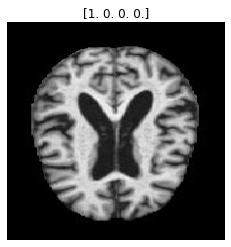

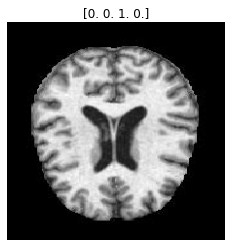

In [4]:
#show flwoers for the first batch

batch_1_img = train_dataset[0]
for i in range(0,2):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

## VGG19

In [5]:
vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

2022-08-06 13:32:25.214701: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-06 13:32:25.215270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 13:32:25.216751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 13:32:25.217765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [6]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [7]:
modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

2022-08-06 13:32:29.907843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-06 13:32:32.313505: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


321/321 [==============================] - 59s 154ms/step - loss: 0.9802 - auc: 0.8552 - acc: 0.6028 - val_loss: 0.7795 - val_auc: 0.8911 - val_acc: 0.6466
Epoch 2/50
321/321 [==============================] - 17s 53ms/step - loss: 0.6507 - auc: 0.9266 - acc: 0.7258 - val_loss: 0.8766 - val_auc: 0.8649 - val_acc: 0.6310
Epoch 3/50
321/321 [==============================] - 17s 54ms/step - loss: 0.4589 - auc: 0.9621 - acc: 0.8063 - val_loss: 0.7029 - val_auc: 0.9110 - val_acc: 0.7013
Epoch 4/50
321/321 [==============================] - 17s 53ms/step - loss: 0.3998 - auc: 0.9708 - acc: 0.8387 - val_loss: 0.8141 - val_auc: 0.8980 - val_acc: 0.6568
Epoch 5/50
321/321 [==============================] - 17s 53ms/step - loss: 0.3484 - auc: 0.9778 - acc: 0.8670 - val_loss: 1.7400 - val_auc: 0.8085 - val_acc: 0.4769
Epoch 6/50
321/321 [==============================] - 17s 53ms/step - loss: 0.2694 - auc: 0.9877 - acc: 0.9000 - val_loss: 0.9747 - val_auc: 0.8767 - val_acc: 0.6216
Epoch 7/50
321

In [8]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 4s 44ms/step - loss: 0.7029 - auc: 0.9110 - acc: 0.7013
Loss:  0.7028596997261047
AUC:  0.9110348224639893
Accuracy:  0.7013291716575623


## VGG16

In [9]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [10]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
321/321 [==============================] - 16s 46ms/step - loss: 0.8770 - auc: 0.8727 - acc: 0.6298 - val_loss: 0.7789 - val_auc: 0.8949 - val_acc: 0.6654
Epoch 2/50
321/321 [==============================] - 15s 47ms/step - loss: 0.5771 - auc: 0.9400 - acc: 0.7666 - val_loss: 0.8149 - val_auc: 0.8974 - val_acc: 0.6646
Epoch 3/50
321/321 [==============================] - 14s 45ms/step - loss: 0.3931 - auc: 0.9728 - acc: 0.8487 - val_loss: 0.7392 - val_auc: 0.9071 - val_acc: 0.6747
Epoch 4/50
321/321 [==============================] - 15s 46ms/step - loss: 0.2978 - auc: 0.9856 - acc: 0.8893 - val_loss: 0.8763 - val_auc: 0.8961 - val_acc: 0.6708
Epoch 5/50
321/321 [==============================] - 15s 46ms/step - loss: 0.2436 - auc: 0.9905 - acc: 0.9190 - val_loss: 0.8292 - val_auc: 0.9052 - val_acc: 0.6904
Epoch 6/50
321/321 [==============================] - 15s 46ms/step - loss: 0.1867 - auc: 0.9958 - acc: 0.9434 - val_loss: 0.8696 - val_auc: 0.9017 - val_acc: 0.6873
Epoc

In [11]:
loss, auc, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 3s 37ms/step - loss: 0.7392 - auc: 0.9071 - acc: 0.6747
Loss:  0.7391741871833801
AUC:  0.9070690274238586
Accuracy:  0.6747459173202515


## ResNet50

In [32]:
rn = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=rn.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
321/321 [==============================] - 20s 52ms/step - loss: 1.9128 - auc: 0.7576 - acc: 0.4829 - val_loss: 1.4363 - val_auc: 0.7513 - val_acc: 0.4996
Epoch 2/50
321/321 [==============================] - 16s 48ms/step - loss: 1.5107 - auc: 0.8061 - acc: 0.5462 - val_loss: 1.1503 - val_auc: 0.8233 - val_acc: 0.5723
Epoch 3/50
321/321 [==============================] - 16s 49ms/step - loss: 1.3908 - auc: 0.8248 - acc: 0.5751 - val_loss: 2.0616 - val_auc: 0.7541 - val_acc: 0.3690
Epoch 4/50
321/321 [==============================] - 16s 49ms/step - loss: 1.2988 - auc: 0.8423 - acc: 0.5860 - val_loss: 0.9961 - val_auc: 0.8439 - val_acc: 0.5817
Epoch 5/50
321/321 [==============================] - 15s 48ms/step - loss: 1.1138 - auc: 0.8648 - acc: 0.6214 - val_loss: 1.8263 - val_auc: 0.6969 - val_acc: 0.3948
Epoch 6/50
321/321 [==============================] - 15s 48ms/step - loss: 1.0702 - auc: 0.8710 - acc: 0.6501 - val_loss: 1.0534 - val_auc: 0.8511 - val_acc: 0.5903
Epoc

In [13]:
loss, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

80/80 [==============================] - 3s 40ms/step - loss: 1.0272 - auc: 0.8430
Loss:  1.0272291898727417
Accuracy:  0.8429989218711853


## ResNet 101

In [16]:
rn = ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=rn.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
321/321 [==============================] - 32s 83ms/step - loss: 1.6128 - auc: 0.7657 - acc: 0.4814 - val_loss: 1.0784 - val_auc: 0.8224 - val_acc: 0.5246
Epoch 2/50
321/321 [==============================] - 24s 76ms/step - loss: 1.2686 - auc: 0.8232 - acc: 0.5602 - val_loss: 2.4120 - val_auc: 0.6374 - val_acc: 0.3698
Epoch 3/50
321/321 [==============================] - 25s 77ms/step - loss: 1.0984 - auc: 0.8481 - acc: 0.5919 - val_loss: 1.4691 - val_auc: 0.7832 - val_acc: 0.4300
Epoch 4/50
321/321 [==============================] - 24s 76ms/step - loss: 0.9649 - auc: 0.8706 - acc: 0.6210 - val_loss: 1.2721 - val_auc: 0.8391 - val_acc: 0.5379
Epoch 5/50
321/321 [==============================] - 24s 76ms/step - loss: 1.1699 - auc: 0.8593 - acc: 0.6159 - val_loss: 1.9416 - val_auc: 0.8096 - val_acc: 0.5927
Epoch 6/50
321/321 [==============================] - 25s 77ms/step - loss: 0.8559 - auc: 0.8964 - acc: 0.6825 - val_loss: 1.2061 - val_auc: 0.8302 - val_acc: 0.5567
Epoc

In [17]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 5s 64ms/step - loss: 1.0697 - auc: 0.8580 - acc: 0.6020
Loss:  1.0696675777435303
AUC:  0.8580460548400879
Accuracy:  0.6020328402519226


## Xception

In [20]:
model = Xception(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=model.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
321/321 [==============================] - 22s 62ms/step - loss: 2.8666 - auc: 0.7851 - acc: 0.5593 - val_loss: 1.7824 - val_auc: 0.8246 - val_acc: 0.5825
Epoch 2/50
321/321 [==============================] - 19s 58ms/step - loss: 1.7325 - auc: 0.8761 - acc: 0.6846 - val_loss: 3.4487 - val_auc: 0.7451 - val_acc: 0.5020
Epoch 3/50
321/321 [==============================] - 18s 57ms/step - loss: 1.3751 - auc: 0.8990 - acc: 0.7391 - val_loss: 2.1722 - val_auc: 0.8262 - val_acc: 0.5942
Epoch 4/50
321/321 [==============================] - 19s 58ms/step - loss: 0.7832 - auc: 0.9445 - acc: 0.8110 - val_loss: 5.6367 - val_auc: 0.7241 - val_acc: 0.5410
Epoch 5/50
321/321 [==============================] - 18s 57ms/step - loss: 0.4337 - auc: 0.9739 - acc: 0.8778 - val_loss: 3.9394 - val_auc: 0.7867 - val_acc: 0.5848
Epoch 6/50
321/321 [==============================] - 18s 57ms/step - loss: 0.6458 - auc: 0.9576 - acc: 0.8453 - val_loss: 2.1337 - val_auc: 0.8291 - val_acc: 0.6083
Epoc

In [21]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 4s 47ms/step - loss: 1.7824 - auc: 0.8246 - acc: 0.5825
Loss:  1.7824040651321411
AUC:  0.8246198296546936
Accuracy:  0.5824863314628601


## MobileNet

In [22]:
model = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=model.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/50
321/321 [==============================] - 14s 39ms/step - loss: 2.5882 - auc: 0.8475 - acc: 0.6702 - val_loss: 2.6967 - val_auc: 0.8380 - val_acc: 0.6622
Epoch 2/50
321/321 [==============================] - 12s 37ms/step - loss: 0.6357 - auc: 0.9622 - acc: 0.8824 - val_loss: 2.4328 - val_auc: 0.8496 - val_acc: 0.6849
Epoch 3/50
321/321 [==============================] - 12s 39ms/step - loss: 0.3809 - auc: 0.9811 - acc: 0.9236 - val_loss: 3.3881 - val_auc: 0.8363 - val_acc: 0.6693
Epoch 4/50
321/321 [==============================] - 12s 37ms/step - loss: 0.2376 - auc: 0.9889 - acc: 0.9498 - val_loss: 3.1374 - val_auc: 0.8320 - val_acc: 0.6654
Epoch 5/50
321/321 [==============================] - 12s 37ms/step - loss: 0.2890 - auc: 0.9856 - acc: 0.9477 - val_loss: 6.0314 - val_auc: 0.7677 - val_acc: 0.5989
Epoch 6/50
321/321 [==============================] - 13s 39ms/step - loss: 0.1757 - auc: 0.9915 - acc: 0

In [23]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 2s 29ms/step - loss: 2.4328 - auc: 0.8496 - acc: 0.6849
Loss:  2.4328389167785645
AUC:  0.8495726585388184
Accuracy:  0.6849100589752197


## MobileNetV2

In [24]:
model = MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=model.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/50
321/321 [==============================] - 17s 44ms/step - loss: 2.8531 - auc: 0.8252 - acc: 0.6255 - val_loss: 2.3895 - val_auc: 0.8196 - val_acc: 0.6138
Epoch 2/50
321/321 [==============================] - 13s 40ms/step - loss: 0.7955 - auc: 0.9494 - acc: 0.8391 - val_loss: 3.1490 - val_auc: 0.8184 - val_acc: 0.6419
Epoch 3/50
321/321 [==============================] - 12s 39ms/step - loss: 0.6076 - auc: 0.9642 - acc: 0.8858 - val_loss: 3.9881 - val_auc: 0.8101 - val_acc: 0.6497
Epoch 4/50
321/321 [==============================] - 12s 39ms/step - loss: 0.3596 - auc: 0.9828 - acc: 0.9264 - val_loss: 4.4053 - val_auc: 0.8115 - val_acc: 0.6396
Epoch 5/50
321/321 [==============================] - 13s 40ms/step - loss: 0.3044 - auc: 0.9843 - acc: 0.9369 - val_loss: 4.0007 - val_auc: 0.8065 - val_acc: 0.6443
Epoch 6/50
321/321 [==============================] - 12s 38ms/step - loss: 0.4331 - auc: 0.9776 - acc: 0.9

In [25]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 2s 30ms/step - loss: 2.3895 - auc: 0.8196 - acc: 0.6138
Loss:  2.389451742172241
AUC:  0.8196309208869934
Accuracy:  0.613760769367218


## DenseNet169

In [26]:
model = DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=model.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/50
321/321 [==============================] - 30s 71ms/step - loss: 3.5551 - auc: 0.8000 - acc: 0.6075 - val_loss: 2.8930 - val_auc: 0.8131 - val_acc: 0.6153
Epoch 2/50
321/321 [==============================] - 19s 60ms/step - loss: 1.0477 - auc: 0.9295 - acc: 0.7922 - val_loss: 3.3776 - val_auc: 0.8068 - val_acc: 0.6208
Epoch 3/50
321/321 [==============================] - 19s 60ms/step - loss: 0.8506 - auc: 0.9461 - acc: 0.8332 - val_loss: 2.4722 - val_auc: 0.8282 - val_acc: 0.6302
Epoch 4/50
321/321 [==============================] - 20s 61ms/step - loss: 0.7997 - auc: 0.9518 - acc: 0.8541 - val_loss: 3.3638 - val_auc: 0.7947 - val_acc: 0.6083
Epoch 5/50
321/321 [==============================] - 19s 59ms/step - loss: 2.1009 - auc: 0.9092 - acc: 0.8080 - val_loss: 4.6307 - val_auc: 0.8086 - val_acc: 0.6380
Epoch 6/50
321/321 [==============================] - 20s 61ms/step - loss: 1.6248 - auc: 0.9414 - acc: 0

In [27]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 4s 50ms/step - loss: 2.4722 - auc: 0.8282 - acc: 0.6302
Loss:  2.4722206592559814
AUC:  0.8282344937324524
Accuracy:  0.6301798224449158


## DenseNet121

In [28]:
model = DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=model.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/50
321/321 [==============================] - 24s 58ms/step - loss: 3.1259 - auc: 0.8040 - acc: 0.5870 - val_loss: 1.5951 - val_auc: 0.8411 - val_acc: 0.5872
Epoch 2/50
321/321 [==============================] - 15s 48ms/step - loss: 1.1252 - auc: 0.9146 - acc: 0.7534 - val_loss: 2.4084 - val_auc: 0.8276 - val_acc: 0.6130
Epoch 3/50
321/321 [==============================] - 16s 51ms/step - loss: 0.8534 - auc: 0.9406 - acc: 0.8110 - val_loss: 3.1793 - val_auc: 0.7636 - val_acc: 0.5207
Epoch 4/50
321/321 [==============================] - 16s 49ms/step - loss: 0.6591 - auc: 0.9581 - acc: 0.8489 - val_loss: 2.3553 - val_auc: 0.8272 - val_acc: 0.6185
Epoch 5/50
321/321 [==============================] - 16s 49ms/step - loss: 0.4431 - auc: 0.9751 - acc: 0.8869 - val_loss: 1.8995 - val_auc: 0.8470 - val_acc: 0.6458
Epoch 6/50
321/321 [==============================] - 16s 50ms/step - loss: 0.5802 - auc: 0.9678 - acc: 0

In [29]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 3s 41ms/step - loss: 1.5951 - auc: 0.8411 - acc: 0.5872
Loss:  1.59514319896698
AUC:  0.8410608768463135
Accuracy:  0.5871774554252625


## InceptionV3

In [30]:
model = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=model.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/50
321/321 [==============================] - 21s 52ms/step - loss: 3.1882 - auc: 0.7908 - acc: 0.5786 - val_loss: 5.5198 - val_auc: 0.6398 - val_acc: 0.4066
Epoch 2/50
321/321 [==============================] - 15s 45ms/step - loss: 1.5306 - auc: 0.8909 - acc: 0.7284 - val_loss: 2.9862 - val_auc: 0.7425 - val_acc: 0.5043
Epoch 3/50
321/321 [==============================] - 14s 44ms/step - loss: 0.9635 - auc: 0.9341 - acc: 0.8047 - val_loss: 2.9028 - val_auc: 0.7588 - val_acc: 0.5184
Epoch 4/50
321/321 [==============================] - 15s 46ms/step - loss: 0.6687 - auc: 0.9599 - acc: 0.8606 - val_loss: 3.4409 - val_auc: 0.7641 - val_acc: 0.5309
Epoch 5/50
321/321 [==============================] - 15s 45ms/step - loss: 1.2785 - auc: 0.9319 - acc: 0.8246 - val_loss: 4.1383 - val_auc: 0.7788 - val_acc: 0.5700
Epoch 6/50
321/321 [==============================] - 14s 44ms/step - loss: 0.6337 - auc: 0.9623 - acc: 0

In [31]:
loss, auc,accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 3s 36ms/step - loss: 2.9028 - auc: 0.7588 - acc: 0.5184
Loss:  2.90277099609375
AUC:  0.7588043212890625
Accuracy:  0.5183737277984619
